In [1]:
import numpy as np
import xarray as xr 
import scipy.linalg as LA
import matplotlib.pyplot as plt 

SEED = 1234567


IC_fp = '../../initialization/coarse/result/glc1-b/nc/glc1-b_3000a_dt_1_dx_50_MB_-1.675_OFF_spline_k2.nc'


with xr.open_dataset(IC_fp) as src: 
    # correct for minimum ice thickness
    src["height"] = xr.where(src.height <= 10, 0, src.height)
    # apply sigma coordinate transform for vertical coordinate
    src["Z"]      = src.zbed + src.Z * src.height 
    # Calculate the magnitude of the velocity vectors
    src['vel_m']  = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)   
    
Vol = src.height.isel(coord_2=-1).integrate("coord_1") /\
      src.height.isel(coord_2=-1).isel(t=0).integrate("coord_1")

class PositiveDegreeDayModel:
    def __init__(self, α, ref_z, T_ma, ΔTΔz, T_p, T_m, T_rs, T_σ):
        """Theano implementation of the (P)ositive (D)egree (D)ay model.

        Inputs:
            α     (float)   --> anual air temp. amplitude    []
            ref_z (float)   --> reference surface elevation  [m a.s.l.]
            T_ma  (float)   --> Mean annual air temp @ ref_z [C]
            ΔTΔz  (float)   --> air temp lapse rate          [K m^-1]
            T_p   (int)     --> DOY of annual temp peak      [DOY]
            T_m   (float)   --> Melting temp. threshold      [C]
            T_rs  (float)   --> rain to snow threshold       [C]
            T_σ   (ndarray) --> std. dev. of air temp as     [C]
                                fuction of DOY

        """
        self.α      = α       # anual air temp. amplitude    []
        self.T_ma   = T_ma    # Mean annual air temp @ ref_z [C]
        self.ΔTΔz   = ΔTΔz    # air temp lapse rate          [K m^-1]
        self.T_p    = T_p     # DOY of annual temp peak      [DOY]
        self.ref_z  = ref_z   # reference surface elevation  [m a.s.l.]
        self.T_m    = T_m     # Melting temp. threshold      [C]
        self.T_rs   = T_rs    # rain to snow threshold       [C]
        self.T_σ    = T_σ     # std. dev. of air temp        [C]

    def calc_air_temp(self, z):
        """"Evaluate the surface air temperature at a given elev. for a given
            day of the year

        Inputs:
            z   (float or Nx1 ndarry) ---> Nodal surface elevation [m a.s.l.]

        Outputs:
            T   (floar or Nx365 ndarray) ---> Nodal surface elevation for each
                                              day of the yeat      [C]
        """
        # Need to seed the Generator every function call to ensure
        # all MCMC steps have the same temperature forcing
        random = np.random.default_rng(SEED)

        # Use array broadcasting to calc temp as function of elevation and doy
        doy  = np.arange(1,366)[:, np.newaxis]
        Temp = self.α * np.cos( 2*np.pi*(doy-self.T_p)/365 ) + \
               self.ΔTΔz * (self.ref_z-z) + self.T_ma + \
               random.normal(0, self.T_σ, (365,1))

        return Temp

def find_ElA(Z, MB): 
    ELA_idx = np.argpartition(np.abs(MB), 2)
    return np.mean(Z[ELA_idx[:2]])

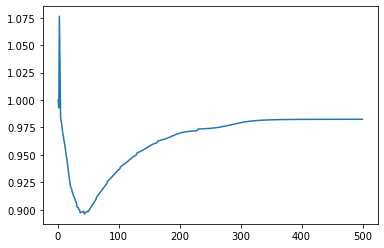

In [115]:
plt.plot(Vol.t[:500], Vol[:500])

In [3]:
# dictionary of PDD model parameters
p = [ 8.29376332e-05, -3.45256005e-02,  6.31076200e+00]
doy = np.arange(1,366)
fancy_std = np.polyval(p, doy)[:, np.newaxis]

const =  dict(T_m = 0.0, 
              T_rs = 1.0, 
              α = 10.8, 
              T_ma = -9.02, 
              ΔTΔz  = 6.5E-3,
              T_p = 196, 
              ref_z = 2193, 
              T_σ = fancy_std)

# initialize the PDD melt model class
PDD_forward = PositiveDegreeDayModel(**const)


H = src.height.isel(t=-1, coord_2 = -1).values
idxs = np.where(H>0)[0]

H = H[idxs]


# Exact Mass Balance from NetCDF
MB = src['zs accumulation flux 2'].isel(t=-1, coord_2 = -1).values
# if we just want to test above the ELA
# idxs = np.intersect1d(idxs, np.where(MB > 0)[0])
MB = MB[idxs]
# Extract surface elevation 
Z  = src.Z.isel(t=-1, coord_2 = -1).values
Z  = Z[idxs]


In [4]:
# X  = src.coord_1.values
# # plt.plot(X,Z)
# plt.plot(X, src['zs'].isel(t=-1, coord_2 = -1).values)
# plt.plot(X, src['zbed'].isel(t=-1, coord_2 = -1).values)

In [94]:
f_i = 5.25
f_s = 3.8
f_r = 0.08

def calc_PDDs(Z): 
    T    = PDD_forward.calc_air_temp(Z)
    PDDs = np.where(T>const['T_m'],T-const['T_m'], 0).sum(axis=0)
    return PDDs

PDDs = calc_PDDs(Z)

Z_ELA = find_ElA(Z, MB)
n_ELA = np.argmin(np.abs(Z-Z_ELA))

R_i   = np.zeros_like(Z)

B_i   = np.zeros_like(Z)
B_ip1 = np.zeros_like(Z)
A_i   = np.zeros_like(Z)
A_ip1 = np.zeros_like(Z)
M_i   = np.zeros_like(Z)

converged = False 

maxitter = 0
i = 0 

# First guess
# calculate local surface melt assuming f_m = f_snow
m_ELA   = f_s*PDDs[n_ELA]
m_0     = MB[0]*910
m_slope = (m_ELA + m_0) / (Z[n_ELA] - Z[0])
m_int   = (m_ELA - m_slope * Z[n_ELA])

M_i = np.where(MB<0, 
               m_slope*Z + m_int, 
               f_s*PDDs)


A_i = MB*910 + M_i
while (not converged) and (i < maxitter):     
    
    A_i = MB*910 + M_i #- R_i
    
    # # check for negative accumulation 
    # if any(A_i < 0): 
    #     corr   = A_i[0]
    #     M_corr = M_i - corr
    #     A_i    = MB*910 + M_corr
    # else: 
    #     M_corr = M_i
        
    # compute the ratio b/w accumulated snow and total melt assuming f_m = f_snow
    with np.errstate(divide='ignore', invalid='ignore'):
        r_s2m = A_i / M_i #M_corr

    # Compute nodal specific degree day factor
    f_m = np.where(r_s2m > 1, 
                   f_s,
                   f_i - (f_i - f_s)*r_s2m)
    
    # # We know the where the ELA is. therefore, we need f_s/f_ice transition manually 
    # f_m = np.where(Z >= Z_ELA, f_s, f_m)
    
    # calculate surface melt [kg m^{-2} yr^{-1}] with f_m
    M_ip1 = (f_m*PDDs)
    A_ip1 = MB*910 + M_i
    B_ip1 = (A_ip1 - M_ip1)/910
    
    if LA.norm(MB - B_ip1) < 1e-6: 
        converged = True
    
    M_i = M_ip1

    i += 1 


In [95]:
Elmer_ELA = find_ElA(Z, MB)
Model_ELA = find_ElA(Z, A_i-M_i)

print(f'Elmer ELA: {Elmer_ELA:.0f}')
print(f'Model ELA: {Model_ELA:.0f}')

Elmer ELA: 2572
Model ELA: 2572


In [96]:
# ref_Z = Z
# ref_A = A_i 
# ref_M = M_i

In [97]:
M_old = (A_i/r_s2m)

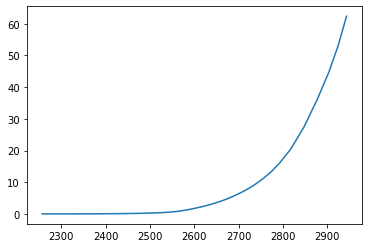

In [98]:
plt.plot(Z, A_i/M_i)
# plt.yscale('log')

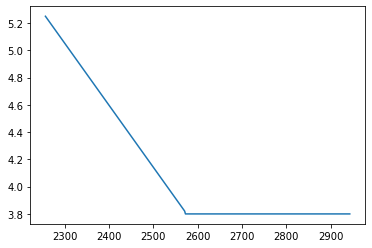

In [99]:
plt.plot(Z, f_m)

In [100]:
Z[np.where(r_s2m >1)[0][1]]

2575.2354

In [101]:
slope = 1 / (Z[np.where(r_s2m >1)[0][1]] - Z[0])
b = 1 - slope*Z[np.where(r_s2m >1)[0][1]]

r_s2m_new = np.where(r_s2m < 1, slope*Z+b, r_s2m)

# Compute nodal specific degree day factor
f_m = np.where(r_s2m_new > 1, 
               f_s,
               f_i - (f_i - f_s)*r_s2m_new)

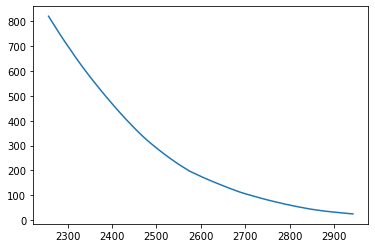

In [102]:
plt.plot(Z, f_m*PDDs)

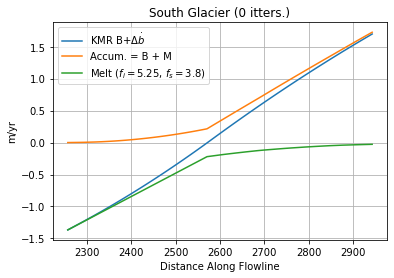

In [105]:
fig, ax =  plt.subplots(1,1)

ax.plot(Z, MB, label=r'KMR B+$\Delta\dot{b}$')
ax.plot(Z, A_i/910, label="Accum. = B + M") 
# ax.plot(Z, R_i /910 )
ax.plot(Z, -M_i/910, label=f'Melt ($f_i={f_i}, \, f_s={f_s}$)')
# ax.plot(Z, (A_i-M_i)/910)

# ax.plot(Z, -(A_i/r_s2m)/910)
ax.legend()

# ax.plot(ref_Z, ref_A/910)
# ax.plot(ref_Z, -ref_M/910)

ax.set_xlabel('Distance Along Flowline')
ax.set_ylabel('m/yr')
ax.set_title(f'South Glacier ({i} itters.)')


ax.grid(which='both')

fig.savefig('A=MB+M_glc1-b_test.png', dpi=300, bbox_inches='tight', facecolor='w')

In [108]:
import scipy.optimize as optim

In [ ]:
def func(b): 
    m = (m_ela - 1) / (x[-1] - x[0]) 
    b = m_ela - x[-1]*z_ela
    
    A = m*x + b 
    M_i = 

In [112]:
np.cos(2*np.pi*1.1)

0.809016994374947

In [111]:
np.cos(2*np.pi*0.1)

0.8090169943749475

In [75]:
np.mean((A_i-M_i)/910)

0.01919253798194858

In [114]:
1.1 % 1

0.10000000000000009

In [ ]:
plt.plot(Z, melt_local/ 910)
plt.plot(Z, A_snow/ 910)
plt.plot(Z, / 910)

In [ ]:
# q_x = (src['velocity 1'].mean(dim='coord_1') * \
#        src.height).isel(coord_2=-1, t=-1).values
# q_z = (src['velocity 2'].mean(dim='coord_1') * \
#        src.height).isel(coord_2=-1, t=-1).values


# X_ = src.coord_1.values
# Z_ = src['Z'].isel(coord_2=-1, t=-1).values

In [ ]:
# plt.plot(X_, src['velocity 1'].isel(coord_2=-1, t=-1).values - np.gradient(q_x, X_) - np.gradient(q_z, Z_))